In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv001.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/MICCAI-2023


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

# FENICSx imports
import ufl, dolfinx
from mpi4py import MPI

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [3]:
def print_array(**kwargs):
    for k, v in kwargs.items():
        print(f'{k} ∈ {v.dtype} {v.shape}')
        
def relative_error(u_true, u_pred):
    return np.linalg.norm(u_true - u_pred) / np.linalg.norm(u_true)

Loading ../data/NAFLD/v4/0006/wave.nc
Loading ../data/NAFLD/v4/0006/mre.nc
Loading ../data/NAFLD/v4/0006/mre_mask.nc


<IPython.core.display.Javascript object>


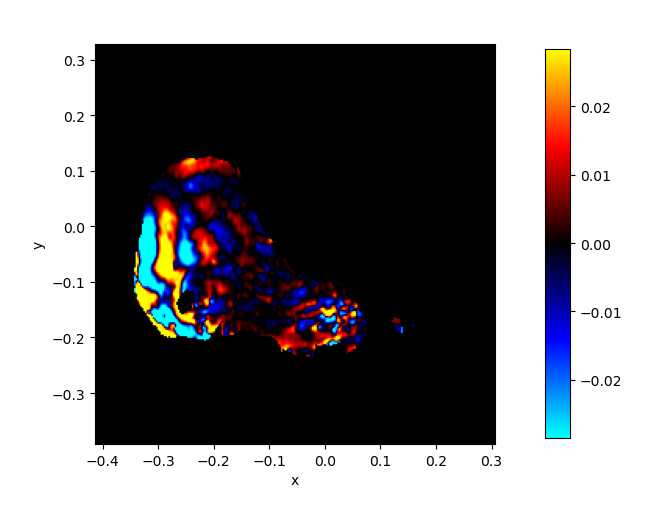

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


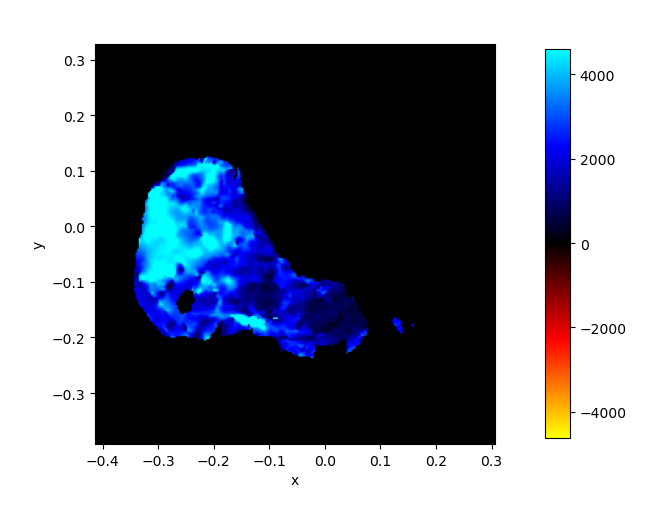

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [4]:
frequency = 40
example = mre_pinn.data.MREExample.load_xarrays('../data/NAFLD/v4/', '0006') # x y
example.view('wave', 'mre', mask=True)

In [5]:
z = example.wave.z[0]
wave = example.wave.sel(z=z)
wave = xr.concat([wave, xr.zeros_like(wave)], dim=xr.DataArray(['x', 'y'], dims='component'))

Kwave = wave.field.smooth(order=2, kernel_size=3)
Jwave = wave.field.gradient(savgol=False)

mre = example.mre.sel(z=z)
ndim = wave.field.n_spatial_dims

x = wave.field.points()
u = wave.field.values()
Ku = wave.field.values()
Ju = Jwave.field.values()
mu = mre.field.values()

print_array(x=x, u=u, Ku=Ku, Ju=Ju, mu=mu)

x ∈ float64 (65536, 2)
u ∈ float64 (65536, 2)
Ku ∈ float64 (65536, 2)
Ju ∈ float64 (65536, 2, 2)
mu ∈ int16 (65536, 1)


In [6]:
# create uniform mesh
mesh = mre_pinn.baseline.fem.create_mesh_from_data(wave, align_nodes=True, mesh_scale=1)

# create FEM basis
scalar_space = dolfinx.fem.FunctionSpace(mesh, element=('DG', 1))
vector_space = dolfinx.fem.VectorFunctionSpace(mesh, element=('CG', 3), dim=ndim)
tensor_space = dolfinx.fem.TensorFunctionSpace(mesh, element=('CG', 3), shape=(ndim, ndim))

# interpolate wave field into FEM basis
u_h = dolfinx.fem.Function(vector_space)
u_h.interpolate(mre_pinn.baseline.fem.create_func_from_data(wave))

# interpolate Jacobian into FEM basis
Ju_h = dolfinx.fem.Function(tensor_space)
Ju_h.interpolate(mre_pinn.baseline.fem.create_func_from_data(Jwave))

In [7]:
# reconstruct elasticity field

# define physical constants
rho = 1000
omega = 2 * np.pi * 40

# set up and solve variational problem
mu_h = ufl.TrialFunction(scalar_space)
v_h = ufl.TestFunction(vector_space)

#A = mu_h * ufl.inner(ufl.grad(u_h), ufl.grad(v_h)) * ufl.dx
A = mu_h * ufl.inner(Ju_h, ufl.grad(v_h)) * ufl.dx
#A -= ufl.inner(ufl.grad(mu_h), Ju_h * v_h) * ufl.dx # hetero
b = rho * omega**2 * ufl.inner(u_h, v_h) * ufl.dx

problem = dolfinx.fem.petsc.LinearProblem(
    A, b, bcs=[], petsc_options={'ksp_type': 'lsqr', 'pc_type': 'none'}
)
mu_h = problem.solve()

# evaluate reconstructed elasticity field
mu_pred = mre_pinn.baseline.fem.eval_dolfinx_func(mu_h, x)

mre_pred = mre_pinn.utils.as_xarray(mu_pred.reshape(mre.shape), like=mre)
mre_pinn.visual.XArrayViewer(mre_pred * example.mre_mask, vmax=5e3, polar=True)

AttributeError: 'NoneType' object has no attribute 'startswith'